In [1]:
import os
import sharedmem
import ctypes
import time
import numpy as np
import matplotlib.pyplot as plt
import popeye.utilities_cclab as utils
from popeye.visual_stimulus import VisualStimulus, simulate_bar_stimulus, resample_stimulus
from popeye.spinach import generate_og_receptive_fields
import popeye.models_cclab as prfModels
# import popeye.css as css
# import popeye.utilities_cclab as utils
import nibabel as nib
from ipywidgets import interact, widgets
from concurrent.futures import ThreadPoolExecutor

%load_ext autoreload
%autoreload 2

In [2]:
viewing_distance = 38.0
screen_width = 25.0
thetas = np.arange(0, 360, 90)
thetas = np.insert(thetas, 0, -1)
thetas = np.append(thetas, -1)
num_blank_steps = 30
num_bar_steps = 30
ecc = 12
tr_length = 1.0
frames_per_tr = 1.0
scale_factor = 1.0
pixels_across = 100
pixels_down = 100
dtype = ctypes.c_int16

In [3]:
# Simulate the bar stimulus
bar = simulate_bar_stimulus(pixels_across, pixels_down, viewing_distance, 
                            screen_width, thetas, num_bar_steps, num_blank_steps, ecc)

# Create the visual stimulus
stimulus = VisualStimulus(stim_arr=bar,
                           viewing_distance=viewing_distance, 
                           screen_width=screen_width, 
                           scale_factor=scale_factor, 
                           tr_length=tr_length, 
                           dtype=dtype)

In [ ]:
print(stimulus.ppd, stimulus.ppd0)

In [ ]:
# Crete an animation through time for stimulus.stim_arr whose third axis is time
def animate(time):
    plt.imshow(stimulus.stim_arr[:, :, time], cmap='gray')
    plt.show()

interact(animate, time=widgets.IntSlider(min=0, max=stimulus.stim_arr.shape[-1]-1, step=1, value=0))

In [ ]:
np.ones((1,n_vox))

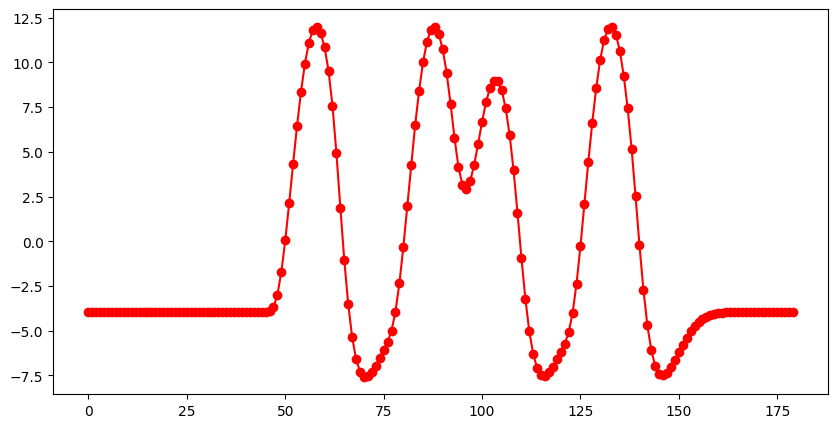

In [23]:
# Initialize a gaussian model
# model = og.GaussianModel(stimulus, utils.spm_hrf)
# model = og.GaussianModel(stimulus, utils.double_gamma_hrf, normalizer=utils.percent_change)
# model = css.CompressiveSpatialSummationModel(stimulus, utils.double_gamma_hrf, utils.percent_change)
model = prfModels.CompressiveSpatialSummationModel(stimulus, utils.double_gamma_hrf)

# model = og.GaussianModel(stimulus, utils.spm_hrf, normalizer=utils.percent_change)

model.hrf_delay = 0
model.mask_size = 6

# Generate a random pRF estimate
# x = -5.24
# y = 1.58
# sigma = 4.24
# beta = 2.0
# baseline = 0.5

# Generate simulated data
n_vox = 25
# Generate random pRF estimates for each voxel
ground_truth = np.empty((n_vox, 9))
ground_truth[:, 0] = np.random.uniform(-10, 10, n_vox) # x
ground_truth[:, 1] = np.random.uniform(-10, 10, n_vox) # y
ground_truth[:, 2] = np.random.uniform(0.25, 5, n_vox) # sigma
ground_truth[:, 3] = np.random.uniform(0.01, 1.0, n_vox) # exponent
ground_truth[:, 4] = np.random.uniform(0, 5, n_vox) # beta
ground_truth[:, 5] = np.random.uniform(-1, 1, n_vox) # baseline
ground_truth[:, 6] = np.ones((1,n_vox)) # R2
ground_truth[:, 7] = np.sqrt(ground_truth[:, 0]**2 + ground_truth[:, 1]**2) # eccentricity
# ground_truth[:, 7] = np.arctan(ground_truth[:, 1], ground_truth[:, 0]) # theta
ground_truth[:, 8] = np.mod(np.arctan2(ground_truth[:, 1], ground_truth[:, 0]),2*np.pi) # theta
# Create a holder for pRF estimates from the model
ballpark_estimates = np.empty((n_vox, ground_truth.shape[-1]))
param_estimates = np.empty((n_vox, ground_truth.shape[-1]))
# x, y = np.random.uniform(-10, 10, n_vox), np.random.uniform(-10, 10, n_vox)
# sigma = np.random.uniform(1, 10, n_vox)
# beta = np.random.uniform(0, 5, n_vox)
# baseline = np.random.uniform(-1, 1, n_vox)
sim_data = np.empty((n_vox, stimulus.stim_arr.shape[-1]))
for i in range(n_vox):
    sim_data[i, :] = model.generate_prediction(ground_truth[i,0], ground_truth[i,1], 
                                               ground_truth[i,2], ground_truth[i,3], 
                                               ground_truth[i,4], ground_truth[i,5])
# sim_data = model.generate_prediction(x, y, sigma, beta, baseline)

# Setting the search grid
Ns = 7
x_grid = utils.grid_slice(-12, 12, Ns*2)
y_grid = utils.grid_slice(-12, 12, Ns*2)
s_grid = utils.grid_slice(0.1, 5.25, Ns)
n_grid = utils.grid_slice(0.1, 1.0, 4)

# Setting the search bounds
x_bound = (-12.0, 12.0)
y_bound = (-12.0, 12.0)
s_bound = (0.001, 6.0)
n_bound = (1e-8, 1.0)
b_bound = (1e-8, None)
m_bound = (None, None)

grids = (x_grid, y_grid, s_grid, n_grid,)
bounds = (x_bound, y_bound, s_bound, n_bound, b_bound, m_bound,)
auto_fit = True
verbose = 0

plt.figure(figsize=(10, 5))
plt.plot(sim_data[1, :], 'ro-')
plt.show()

In [24]:
# Fit the response
# fit = og.GaussianFit(model, data=sim_data, grids=grids, bounds=bounds)  
def process_voxel(ijk):
    if np.mod(ijk, 100) == 0:
        run_time = time.time() - start_time
        if run_time < 60:
            print(f"Finished: {round(ijk/n_vox*100, 2)}%, time: {round(run_time, 2)} s")
        elif run_time < 3600:
            print(f"Finished: {round(ijk/n_vox*100, 2)}%, time: {int(np.floor(run_time/60))} min {round(run_time%60)} s")
        else:
            print(f"Finished: {round(ijk/n_vox*100, 2)}%, time: {int(np.floor(run_time/3600))} h {int(np.floor(run_time%3600/60))} min {round(run_time%60)} s")
    th_data = sim_data[ijk, :]
    
    fit = prfModels.CompressiveSpatialSummationFit(
        model,
        th_data,
        grids,
        bounds,
        (ijk, 0, 0),
        Ns=None,
        auto_fit=auto_fit,
        grid_only=True,
        verbose=verbose
    )
    return (ijk, fit.x0, fit.y0, fit.s0, fit.n0, fit.beta0, fit.baseline0,
            fit.x, fit.y, fit.sigma, fit.n, fit.beta, fit.baseline, fit.rsquared, fit.rho, fit.theta)

start_time = time.time()

futures = []
with ThreadPoolExecutor() as executor:
    for ijk in range(n_vox):
        futures.append(executor.submit(process_voxel, ijk))

results = [f.result() for f in futures]

for result in results:
    if result is not None:
        ijk, x0, y0, s0, n0, beta0, baseline0, x, y, sigma, n, beta, baseline, rsquared, rho, theta = result
        ballpark_estimates[ijk, 0] = x0
        ballpark_estimates[ijk, 1] = y0
        ballpark_estimates[ijk, 2] = s0
        ballpark_estimates[ijk, 3] = n0
        ballpark_estimates[ijk, 4] = beta0
        ballpark_estimates[ijk, 5] = baseline0
        ballpark_estimates[ijk, 6] = rsquared
        ballpark_estimates[ijk, 7] = rho
        ballpark_estimates[ijk, 8] = theta

        param_estimates[ijk, 0] = x
        param_estimates[ijk, 1] = y
        param_estimates[ijk, 2] = sigma
        param_estimates[ijk, 3] = n
        param_estimates[ijk, 4] = beta
        param_estimates[ijk, 5] = baseline
        param_estimates[ijk, 6] = rsquared
        param_estimates[ijk, 7] = rho
        param_estimates[ijk, 8] = theta

end_time = time.time()
print()
print(f"Time taken for fitting: {end_time - start_time}")

Finished: 0.0%, time: 0.0 s

Time taken for fitting: 215.79545092582703


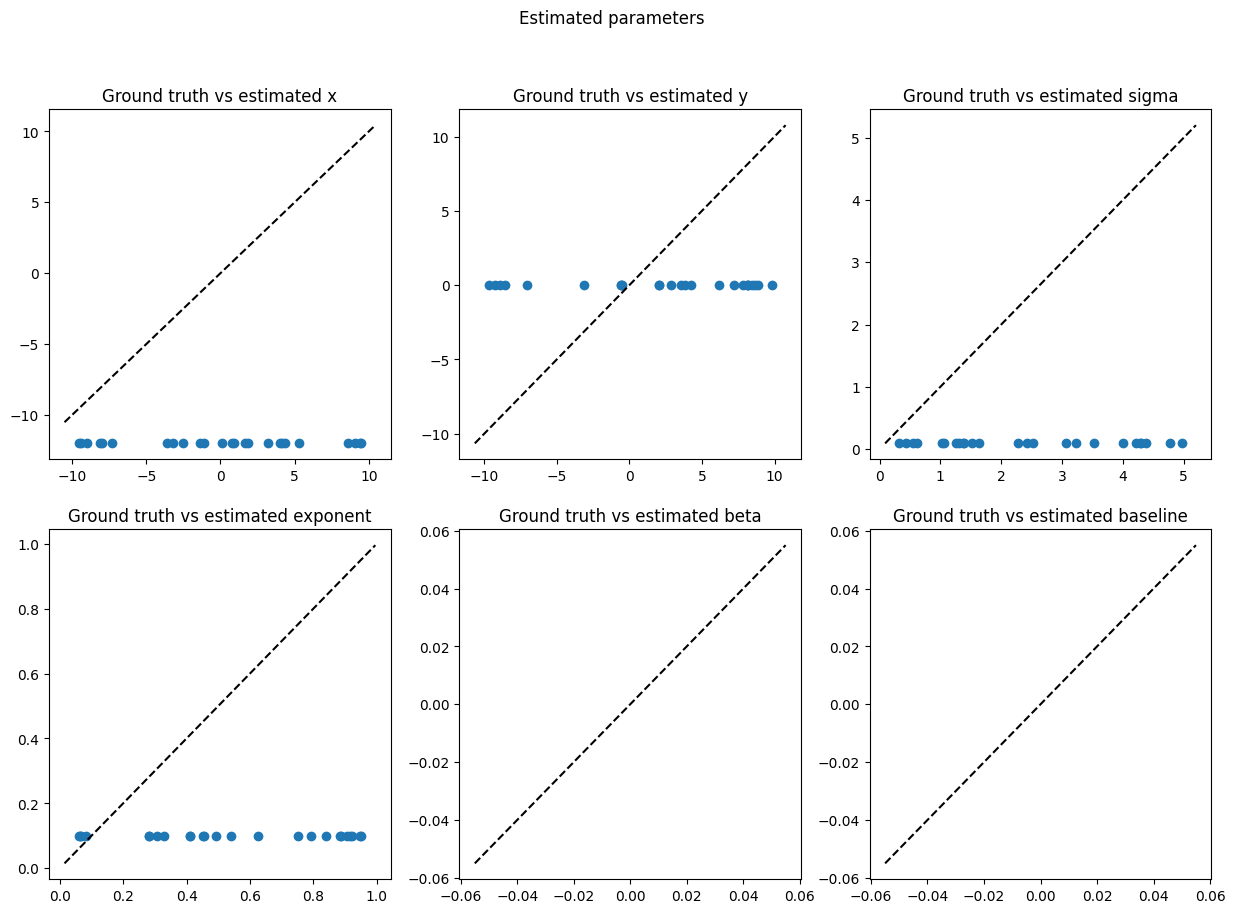

In [22]:
# Plot ground_truth and estimated parameters
f, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    ax = axs.flatten()[i]
    ax.plot(ground_truth[:, i], param_estimates[:, i], 'o')
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    ax.set_title(f"Ground truth vs estimated {['x', 'y', 'sigma', 'exponent','beta', 'baseline', 'R2', 'rho', 'theta'][i]}")
plt.suptitle("Estimated parameters")
plt.show()

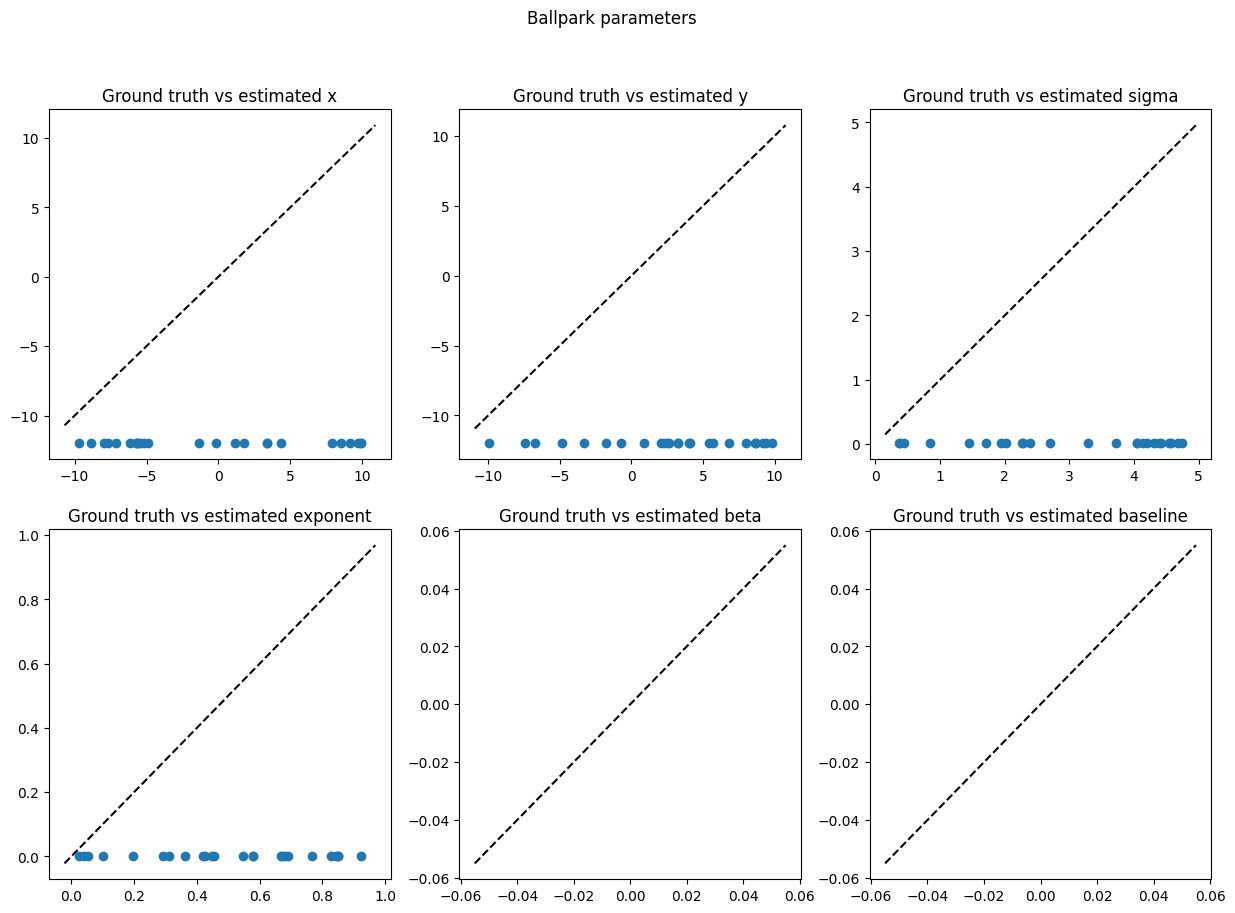

In [7]:
# Plot ground_truth and estimated parameters
f, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    ax = axs.flatten()[i]
    ax.plot(ground_truth[:, i], ballpark_estimates[:, i], 'o')
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    ax.set_title(f"Ground truth vs estimated {['x', 'y', 'sigma', 'exponent','beta', 'baseline', 'R2', 'rho', 'theta'][i]}")
plt.suptitle("Ballpark parameters")
plt.show()

In [ ]:
# Visualize the landscape of the cost function
